## 1st Midterm(2024) - Assignment 7 - Alice Nicoletta
"Implement the convolution of a Laplacian of a Gaussian blob (LoG) detector with an image and apply it to 3-4 images of your choice from the dataset. Do not use library functions for implementing the convolution or to generate the LoG filter. Implement your own and show the code (the interesting bits at least)! The function you implement should be able to run the LoG for different choices of the scale parameter, which is passed as an input argument. Show the results of your code on the 3-4 example images, for different choices of the scale parameter (sigma)."

In [2]:
import numpy as np
import cv2 # OpenCV
import matplotlib.pyplot as plt
import seaborn as sns

img = cv2.imread('./weizmann_horse_db/horse/horse001.png', cv2.IMREAD_GRAYSCALE)

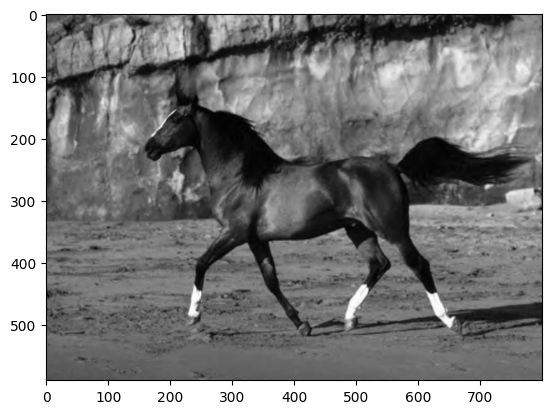

In [8]:
plt.imshow(img, cmap='gray')
plt.show()

Let's implement the convolution function between image and kernel.

In [3]:
#convolution
def convolution(img, kernel) -> np.ndarray:
    h1, w1 = img.shape
    h2, w2 = kernel.shape

    img = np.pad(img, (h2//2, w2//2), 'constant')

    conv_img = np.zeros((h1, w1))
    for i in range(h1):
        for j in range(w1):
            conv_img[i,j] = (img[i:i+h2 , j:j+w2] * kernel).sum()
    return conv_img


Let's now implement the Laplacian of Gaussian, through this formula:
$$\nabla^2 g_\sigma(x,y)=\frac{\partial^2 g_\sigma}{\partial^2 x}+\frac{\partial^2 g_\sigma}{\partial^2 y}=\frac{1}{\pi \sigma^4}(\frac{x^2+y^2}{\sigma^2}-1)e^{-\frac{x^2+y^2}{2\sigma^2}}$$
and we normalize it by multypling by $\sigma$.

In [4]:
def lapl(x,y,sigma):
    a = (x**2 + y**2) / (2*sigma**2)
    b=np.pi*sigma**2
    return (a - 1)*np.exp(-a)/b

#Laplacian of Gaussian
def LoG(sz, sigma) -> np.ndarray:
    kernel=np.zeros((sz,sz))
    for i in range(sz):
        for j in range(sz):
            kernel[i,j] = lapl(i-sz//2,j-sz//2,sigma)
    return kernel

We can test the LoG function with a plot of a kernel of size 21 and $\sigma=2$.

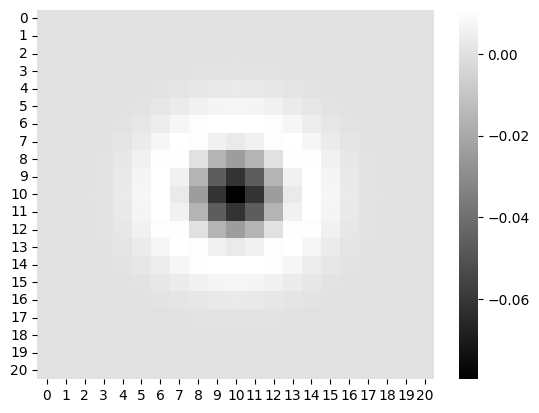

In [33]:
A=LoG(21,2)
sns.heatmap(A, cmap='gray')
plt.show()

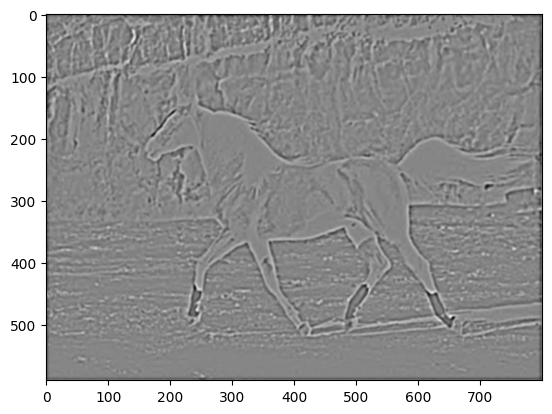

In [34]:
img = cv2.imread('./weizmann_horse_db/horse/horse001.png', cv2.IMREAD_GRAYSCALE)
modd=convolution(img, A)
plt.imshow(modd, cmap='gray')
plt.show()

The LoG and convolution functions seem to work as intended.

# Blob Detection

The naive way to solve the blob detection task would be to find some maxima on the each space-scale (so a 3-dimensional maximum problem) and then threshold by the value of the squared LoG response: 
$$(x^*,y^*,\sigma^*)=\underset{x,y,\sigma}{\text{argmax}} \:[\nabla^2_\sigma g\ast I (x,y)]^2$$
Then, knowning that  the filter has maximum response when centered on a circle of radius $\sqrt{2}\sigma$, we can draw each circle of radius $\sqrt{2}\sigma^*$ centered in $(x^*,y^*)$.

However, by doing this we would catch too many blobs in the same area with similar response, so later we define a grid to avoid this.

Let's now define a function to create various scale spaces by changing the $\sigma$.

In [52]:
def generate_scale_space(img , scales , kernel_size) -> np.ndarray:
    b=(img.shape[0],img.shape[1],scales.size)
    a=np.zeros(b)
    for i in range(scales.size):
        kernel=LoG(kernel_size,scales[i])
        conv_img=convolution(img,kernel)
        a[:,:,i]=conv_img
      

    return a


Now we define a function to draw circles in the coordinates and with the radius=$\sqrt{2}\sigma$.

In [54]:
from matplotlib.patches import Circle
def draw_circ(coords,scales):    
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    for i in range(coords.shape[0]):
        circ = Circle((coords[i,0], coords[i,1]),np.sqrt(2)*scales[coords[i,2]], fill=False, color='red')
        ax.add_patch(circ)
    ax.imshow(img, cmap='gray')
    plt.show()

Now we can use this function "grid" to create a grid of $10\times 10$ squares in the image and find a maximum for each square.

In [148]:
def grid(A, grid_size)->np.ndarray:
    count=0
    X=np.arange(grid_size,A.shape[0],grid_size)
    Y=np.arange(grid_size,A.shape[1],grid_size)
    n_blobs=X.shape[0]*Y.shape[0]
    coords=np.zeros((n_blobs,3))
    for i in X:
        for j in Y:
            argmx=A[i-grid_size:i , j-grid_size:j , :].argmax()
            coords[count,:]=np.unravel_index(argmx, (grid_size, grid_size ,A.shape[2]))
            coords[count,0]=coords[count,0]+i
            coords[count,1]=coords[count,1]+j
            count=count+1
    return coords


In [53]:
img = cv2.imread('./bunny002.jpg', cv2.IMREAD_GRAYSCALE)
import math
sigma_start=10
sigma_end=20
sigma_step=2
scale_vec = np.arange(sigma_start, sigma_end, sigma_step)

a=generate_scale_space(img=img/255,
    scales=scale_vec,
    kernel_size=math.floor(2*np.sqrt(2)*20+20),
     )

In [125]:
blobs=grid(a,10)
blobs=blobs.astype(int)
blobs.dtype

dtype('int32')

In [166]:
threshold=0.16
coords=np.argwhere(a[blobs] > threshold)
coords.shape

(1138, 4)